# Setup

In [1]:
# Install necessary packages

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import sklearn
import nltk

# The following are not included with anaconda so have pip install commands

#!pip install weka
#!pip install gensim
#!pip install textblob
#import weka
import gensim
from textblob import TextBlob

import json

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

In [3]:
# Get datasets and place into dataframes
# Attempt to read from local file first
# Read from url if impossible and create local file for future use

columns = ["label", "comment", "author", "subreddit", "score", "ups", "downs", "date", "created_utc", "parent_comment"]

try:
    print("Reading from file...")
    test_balanced = pd.read_csv('data/test-balanced.csv.bz2', compression='bz2')
    train_balanced = pd.read_csv('data/train-balanced.csv.bz2', compression='bz2')
    print("Read successfully!")
except:
    print("No local file")
    print("Downloading...")
    test_balanced = pd.read_csv("http://nlp.cs.princeton.edu/SARC/1.0/main/test-balanced.csv.bz2", compression="bz2", sep="\t", header=None, names=columns)
    train_balanced = pd.read_csv("http://nlp.cs.princeton.edu/SARC/1.0/main/train-balanced.csv.bz2", compression="bz2", sep="\t", header=None, names=columns)
    print("Downloaded!")
    print("Creating local copy...")
    test_balanced.to_csv('data/test-balanced.csv.bz2', compression='bz2', index=False)
    train_balanced.to_csv('data/train-balanced.csv.bz2', compression='bz2', index=False)
    print("Local copy created successfully!")

Reading from file...
Read successfully!


In [4]:
data_types = {
    "label": "int",
    "comment": "unicode",
    "author": "unicode",
    "subreddit": "unicode",
    "score": "int",
    "ups": "int",
    "downs": "int",
    "date": "object",
    "created_utc": "object",
    "parent_comment": "unicode"
}

train_balanced = train_balanced.astype(data_types)
test_balanced = test_balanced.astype(data_types)

In [5]:
train_balanced['datetime'] = pd.to_datetime(train_balanced['created_utc'], unit='s')
test_balanced['datetime'] = pd.to_datetime(test_balanced['created_utc'], unit='s')

In [6]:
# So as not to run out of memory, only use a part of the dataset

n_samples = 10000
train = pd.concat((
    train_balanced[train_balanced['label'] == 1].sample(n=int(n_samples/2)),
    train_balanced[train_balanced['label'] == 0].sample(n=int(n_samples/2))
)).sample(frac=1)
test = pd.concat((
    test_balanced[test_balanced['label'] == 1].sample(n=int(n_samples/8)),
    test_balanced[test_balanced['label'] == 0].sample(n=int(n_samples/8))
)).sample(frac=1)

train = train_balanced
test = test_balanced

In [7]:
# Tokenizer function

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')

def tokenize(string):
    normalized_tokens = list()
    tokens = tokenizer.tokenize(string)
    for token in tokens:
        if (len(token) > 1):
            normalized = token.lower()
            normalized_tokens.append(normalized)
    return normalized_tokens

def stem_tokenizer(string):
    normalized_tokens = list()
    tokens = tokenizer.tokenize(string)
    for token in tokens:
        if len(token) > 1:
            normalized = token.lower()
            normalized = stemmer.stem(normalized)
            normalized_tokens.append(normalized)
    return normalized_tokens

def stop_tokenizer(string):
    normalized_tokens = list()
    tokens = tokenizer.tokenize(string)
    for token in tokens:
        if token.lower() not in stop_words and len(token) > 1:
            normalized = token.lower()
            normalized_tokens.append(normalized)
    return normalized_tokens

def stem_stop_tokenizer(string):
    normalized_tokens = list()
    tokens = tokenizer.tokenize(string)
    for token in tokens:
        if token.lower() not in stop_words and len(token) > 1:
            normalized = token.lower()
            normalized = stemmer.stem(normalized)
            normalized_tokens.append(normalized)
    return normalized_tokens

[nltk_data] Downloading package stopwords to /home/summer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Evaluation function

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

def eval_summary(name, predictions, labels):
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    print('\nConfusion matrix:\n',confusion_matrix(labels, predictions))
    print("Classifier '%s' has P=%0.3f R=%0.3f Acc=%0.3f F1=%0.3f" % (name, precision, recall, accuracy, f1))
    print(classification_report(labels, predictions))
    return f1

In [9]:
# Sklearn packages

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

from multiprocessing import pool, cpu_count

In [10]:
# Handle other packages

from datetime import datetime, timedelta

from gensim.models.ldamodel import  LdaModel
from gensim.corpora import Dictionary

from scipy.sparse import csr_matrix

from multiprocessing import Pool, cpu_count

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/summer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
# Transformation classes
    
class SubredditSarcasm(BaseEstimator, TransformerMixin):
    def __init__(self, history=None):
        self.history = history
        
    def fit(self, X, y=None):
        if (self.history == None):
            self.history = {}
            for _, post in X.iterrows():
                if post['subreddit'] not in self.history:
                    self.history[post['subreddit']] = {'0': 0, '1': 1}
                
                self.history[post['subreddit']][str(post['label'])] += 1
                    
        return self
    
    def transform(self, X):
        return X.apply(lambda x: self.getSarcasmHistory(x['subreddit']), axis=1)
    
    def getSarcasmHistory(self, subreddit):
        try:
            return(self.history[subreddit]['1'] / (self.history[subreddit]['0'] + self.history[subreddit]['1']))
        except:
            return 0.0
    
class AuthorSarcasm(BaseEstimator, TransformerMixin):
    def __init__(self, history=None):
        self.history = history
        
    def fit(self, X, y=None):
        if (self.history == None):
            self.today = X.sort_values(by=['datetime'], ascending=False).iloc[0]['datetime']
            self.last_week = self.today - timedelta(weeks=1)
            self.last_month = self.last_week - timedelta(weeks=4)
            self.last_six_months = self.last_month - timedelta(weeks=24)
            self.last_year = self.last_six_months - timedelta(days=365)
            
            self.history = {}
            zero_times = {
                'last_month': 0,
                'last_six_months': 0,
                'last_year': 0,
                'earlier': 0
            }
            
            for _, post in X.iterrows():
                if post['author'] not in self.history:
                    self.history[post['author']] = {0: zero_times.copy(), 1: zero_times.copy()}
                    
                if (post['datetime'] >= self.last_month):
                    time = 'last_month'
                elif (post['datetime'] >= self.last_six_months):# and post['datetime'] < self.last_week):
                    time = 'last_six_months'
                elif (post['datetime'] >= self.last_year):# and post['datetime'] < self.last_month):
                    time = 'last_year'
                else:
                    time = 'earlier'
                    
                self.history[post['author']][post['label']][time] += 1
            
        return self
    
    def transform(self, X):            
        return np.vstack(X.apply(lambda x: self.getAuthorSarcasmHistory(x['author']), axis=1))
    
    def getAuthorSarcasmHistory(self, author):
        author_hist = np.zeros(4)
        for i, time in enumerate(['last_week', 'last_month', 'last_year', 'earlier']):
            try:
                author_hist[i] = float(
                    self.history[author][1][time] / (self.history[author][0][time] + self.history[author][1][time])
                )
            except:
                author_history[i] = 0.0
        return np.sum(author_hist)
    
class OverallSentiment(BaseEstimator, TransformerMixin):
    '''Returns the sentiment of each document'''
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        sentiments = np.zeros((len(X), 2))
        for i, x in enumerate(X):
            sent = TextBlob(x).sentiment
            sentiments[i][0] = sent.polarity
            sentiments[i][1] = sent.subjectivity
        return sentiments
    
class Polarity(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda comment: TextBlob(comment).polarity)
    
class Subjectivity(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda comment: TextBlob(comment).subjectivity)
    
class SentimentDifference(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda x: self.getSentDiff(x))
    
    def getSentDiff(self, comment):
        blob = TextBlob(comment)
        sentences = blob.sentences
        
        if (len(sentences) == 1):
            words = blob.words
            l = len(words)
            first = words[:int(l/2)]
            second = words[int(l/2):]
            return abs(TextBlob(str(first)).subjectivity - TextBlob(str(second)).sentiment.subjectivity)
        
        else:
            l = len(sentences)
            first = sentences[:int(l/2)]
            second = sentences[int(l/2):]
            return abs(
                np.mean([sentence.subjectivity for sentence in first]) -
                np.mean([sentence.subjectivity for sentence in second])
            )
    
class TopicExtractor(BaseEstimator, TransformerMixin):
    '''Returns the most prominent topics for each document in the corpus'''
    def __init__(
        self,
        num_topics=100,
        display=False,
        minimum_probability=0.01,
        ldaModel=None,
        dictionary=None,
        alpha=1,
        tokenizer=stem_stop_tokenizer,
        n_workers=None
    ):
        self.num_topics = num_topics
        self.display = display
        self.minimum_probability = minimum_probability
        self.ldaModel = ldaModel
        self.dictionary = dictionary
        self.alpha = alpha
        self.tokenize = tokenizer
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
    
    def fit(self, X, y=None):
        if (self.ldaModel == None):
            self.display and print("Tokenizing coments...")
            tokenized_text = X.apply(lambda comment: self.tokenize(comment))
            self.display and print("Preparing dictionary...")
            self.dictionary = Dictionary(tokenized_text)
            self.display and print("Creating corpus...")
            corpus = [self.dictionary.doc2bow(text) for text in tokenized_text]

            self.display and print("Initializing LDA Model...")
            self.ldaModel = LdaMulticore(
                corpus,
                num_topics=self.num_topics,
                id2word=self.dictionary,
                alpha=self.alpha,
                minimum_probability=self.minimum_probability
            )

            self.display and print("Done!\n")
            if (self.display):
                for topics in self.ldaModel.print_topics():
                    print(topics)
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        topics = pool.map(self.getTopics, X)
        pool.close()
        return np.vstack(topics)
        
        #tokenized_text = X.apply(lambda comment: self.tokenize(comment))
        #corpus = [self.dictionary.doc2bow(text) for text in tokenized_text]
        #all_doc_topics = [self.ldaModel[doc] for doc in corpus]
        #
        #data = list()
        #rows = list()
        #cols = list()
        #for i, doc_topics in enumerate(all_doc_topics):
        #    for topic in doc_topics:
        #        data.append(topic[1])
        #        rows.append(i)
        #        cols.append(topic[0])
        #
        #return scipy.sparse.csr_matrix((data, (rows, cols)), shape=(len(corpus), self.num_topics))
    
    def getTopics(self, comment):
        topics = self.ldaModel.get_document_topics(
            self.dictionary.doc2bow(self.tokenize(comment)),
            minimum_probability = self.minimum_probability
        )
        
        topic_matrix = np.zeros(100)
        for topic in topics:
            topic_matrix[topic[0]] = topic[1]
            
        return topic_matrix
    
class PoSTags(BaseEstimator, TransformerMixin):
    def __init__(self):
        all_tags = [
            '$', '\'\'', '(', ')', ',', '--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS',
            'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
            'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', 'None'
        ]
        
        self.tag_to_i = {}
        for i, tag in enumerate(all_tags):
            self.tag_to_i[tag] = i
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.vstack(X.apply(lambda x: self.getPoSTags(x)))
    
    def getPoSTags(self, comment):
        tokens = tokenize(comment)
        tags = nltk.pos_tag(tokens)
        ret = np.zeros(len(self.tag_to_i))
        
        for tag in tags:
            ret[self.tag_to_i[tag[1]]] += 1
            
        return np.nan_to_num(ret / len(tokens))
    
class N_sentences(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda comment: len(TextBlob(comment).sentences))
    
class CommentLength(BaseEstimator, TransformerMixin):
    def __init__(self, term="sentence", n_workers=None):
        self.term = term
        if (n_workers == None):
            self.n_workers = cpu_count() -1
        else:
            self.n_workers = n_workers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        lengths = pool.map(self.getLength, X)
        pool.close()
        return lengths
        
    def getLength(self, comment):
        if (self.term == "character"):
            return len(comment)
        elif (self.term == "word"):
            return len(TextBlob(comment).words)
        elif (self.term == "sentence"):
            return len(TextBlob(comment).sentences)
    
class SentDiffPerSentence(BaseEstimator, TransformerMixin):
    def __init__(self, agg=np.mean):
        self.agg = agg
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda comment: self.getSentDiff(comment))
    
    def getSentDiff(self, comment):
        sentences = TextBlob(comment).sentences
        diffs = np.zeros(len(sentences))
        
        for i, sentence in enumerate(sentences):
            words = sentence.words
            l = len(words)
            
            diffs[i] = abs(TextBlob(str(words[:int(l/2)])).subjectivity - TextBlob(str(words[int(l/2):])).subjectivity)
            
        return self.agg(diffs)

In [12]:
# Utility classes

class ColumnSelector(BaseEstimator, TransformerMixin):
    '''Returns a single column from a dataframe'''
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.column]

class OneDReshaper(BaseEstimator, TransformerMixin):
    '''Converts a 1D array to a 2D array with one dimension 1 to fit scikit-learn transformers'''
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.values.reshape(-1, 1)
    
class ToArray(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.toarray()
    
class ToNpArray(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        arr = np.array(X)
        return arr.reshape(-1, 1)
    
class Printer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print(X[:20])
        print(X.shape)
        return X

In [13]:
# Get existing model data is possible

try:
    with open('models/author_history.json') as f:
        author_history = json.load(f)
    print("Author sarcasm history read from file")
except:
    author_history = None
    print("No author sarcasm history - will be constructed from training data")

try:
    with open('models/subreddit_history.json') as f:
        subreddit_history = json.load(f)
    print("Subreddit sarcasm history read from file")
except:
    subreddit_history = None
    print("No subreddit sarcasm history - will be constructed from training data")
    
try:
    ldaModel = LdaModel.load('models/ldamodel.model')
    dictionary = Dictionary.load('models/dictionary.dict')
    print("LDAModel and dictionary read from file")
except:
    ldaModel = None
    dictionary = None
    print("No LDAModel or dictionary - will be constructed from training data")
    
try:
    parent_ldaModel = LdaModel.load('models/parent_ldamodel.model')
    parent_dictionary = Dictionary.load('models/parent_dictionary.dict')
    print("LDAModel and dictionary read from file")
except:
    parent_ldaModel = None
    parent_dictionary = None
    print("No parent comment LDAModel or dictionary - will be constructed from training data")

Author sarcasm history read from file
Subreddit sarcasm history read from file
LDAModel and dictionary read from file
LDAModel and dictionary read from file


In [14]:
# Test on different parameters and ouput graph

def paramTest(clf, param, params, fname=None, param_names=None, train=train, test=test, title="", x_label="", y_label="F1 Score"):
    f1_scores = list()
    if (param_names == None):
        p_names = list()
    else:
        p_names = param_names
    
    for i, var in enumerate(params):
        if (param_names == None):
            p_names.append(str(var))
            
        clf.set_params(**{param: var})
        clf.fit(train, train['label'])
        f1_scores.append(eval_summary("{} - {}".format(param, p_names[i]), clf.predict(test), test['label']))
        
    if fname is not None:
        plt.figure()
        plt.tight_layout()
        plt.bar(range(len(f1_scores)), f1_scores)
        for i, f1 in enumerate(f1_scores):
            plt.text(i, f1 + 0.02, '%.3f' % f1, horizontalalignment='center', fontsize=12)

        plt.xticks(range(len(p_names)), p_names, rotation='vertical')
        plt.ylim(0,1)

        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.savefig('graphs/{}.png'.format(fname), bbox_inches="tight")
        
    return f1_scores

In [15]:
def plotBar(data, ticks=None, title=None, x_label=None, y_label=None, y_lim=None, vals=True, saveas=None):
    plt.figure()
    plt.tight_layout()
    
    plt.bar(range(len(data)), data)
    
    if (vals):
        for i, d in enumerate(data):
            plt.text(i, d + 0.02, '%.3f' % d, horizontalalignment='center', fontsize=12)
    
    if (ticks is not None):
        plt.xticks(range(len(ticks)), ticks, rotation='vertical')
    if (title is not None):
        plt.title(np.array(title))
    if (x_label is not None):
        plt.xlabel(x_label)
    if (y_label is not None):
        plt.ylabel(y_label)
    if (y_lim is not None):
        if (isinstance(y_lim, tuple)):
            plt.ylim(y_lim)
        else:
            plt.ylim(top=y_lim)
            
    if (saveas != None):
        plt.savefig("graphs/{}.png".format(saveas), bbox_inches="tight")

# N-grams

In [17]:
ngram_clf = Pipeline([
    ('selector', ColumnSelector('comment')),
    ('vect', TfidfVectorizer(binary=True)),
    ('clf', LogisticRegression())
])

## N-gram range


Confusion matrix:
 [[102681  38986]
 [ 48207  93460]]
Classifier 'vect__ngram_range - (1, 1)' has P=0.706 R=0.660 Acc=0.692 F1=0.682
             precision    recall  f1-score   support

          0       0.68      0.72      0.70    141667
          1       0.71      0.66      0.68    141667

avg / total       0.69      0.69      0.69    283334


Confusion matrix:
 [[107377  34290]
 [ 49172  92495]]
Classifier 'vect__ngram_range - (2, 2)' has P=0.730 R=0.653 Acc=0.705 F1=0.689
             precision    recall  f1-score   support

          0       0.69      0.76      0.72    141667
          1       0.73      0.65      0.69    141667

avg / total       0.71      0.71      0.70    283334


Confusion matrix:
 [[110819  30848]
 [ 65715  75952]]
Classifier 'vect__ngram_range - (3, 3)' has P=0.711 R=0.536 Acc=0.659 F1=0.611
             precision    recall  f1-score   support

          0       0.63      0.78      0.70    141667
          1       0.71      0.54      0.61    141667

avg / t

[0.681908555960498,
 0.6890989823134116,
 0.611364889502429,
 0.7207167769437228,
 0.6929230678064029,
 0.725678888661554]

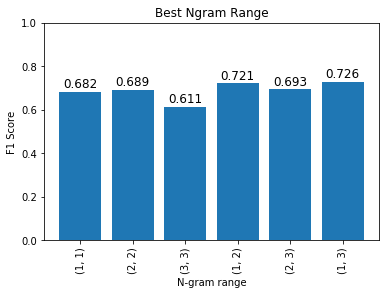

In [17]:
ngram_range = [(1, 1), (2, 2), (3,3), (1, 2), (2, 3), (1, 3)]
paramTest(ngram_clf, 'vect__ngram_range', ngram_range, "best_ngram_range", x_label="N-gram range", title="Best Ngram Range")

## Classifier Parameters


Confusion matrix:
 [[104285  37382]
 [ 54302  87365]]
Classifier 'clf__C - 0.01' has P=0.700 R=0.617 Acc=0.676 F1=0.656
             precision    recall  f1-score   support

          0       0.66      0.74      0.69    141667
          1       0.70      0.62      0.66    141667

avg / total       0.68      0.68      0.68    283334


Confusion matrix:
 [[105794  35873]
 [ 46875  94792]]
Classifier 'clf__C - 0.1' has P=0.725 R=0.669 Acc=0.708 F1=0.696
             precision    recall  f1-score   support

          0       0.69      0.75      0.72    141667
          1       0.73      0.67      0.70    141667

avg / total       0.71      0.71      0.71    283334


Confusion matrix:
 [[105071  36596]
 [ 41238 100429]]
Classifier 'clf__C - 1' has P=0.733 R=0.709 Acc=0.725 F1=0.721
             precision    recall  f1-score   support

          0       0.72      0.74      0.73    141667
          1       0.73      0.71      0.72    141667

avg / total       0.73      0.73      0.73    2833

[0.6558589263327004,
 0.6961502871495087,
 0.7207167769437228,
 0.7127645663920724,
 0.6873991388483682]

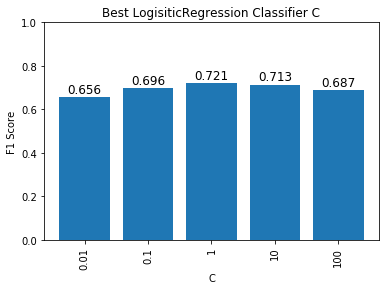

In [18]:
ngram_clf.set_params(vect__ngram_range=(1,2))
paramTest(ngram_clf, 'clf__C', [0.01, 0.1, 1, 10, 100], "best_logreg_c", x_label="C", title="Best LogisiticRegression Classifier C")

## Tokenizer

In [19]:
ngram_clf.set_params(clf__C=0.1)

tokenizers = [None, stem_tokenizer, stop_tokenizer, stem_stop_tokenizer]
tokenizer_names = ["Whitespace", "w/ stemming", "w/ stopwords", "w/ stemming and stopwords"]

paramTest(ngram_clf, "vect__tokenizer", tokenizers, "best_tokenizer", param_names=tokenizer_names, x_label="Tokenizer", title="Best Tokenizer")


Confusion matrix:
 [[105794  35873]
 [ 46875  94792]]
Classifier 'vect__tokenizer - Whitespace' has P=0.725 R=0.669 Acc=0.708 F1=0.696
             precision    recall  f1-score   support

          0       0.69      0.75      0.72    141667
          1       0.73      0.67      0.70    141667

avg / total       0.71      0.71      0.71    283334



KeyboardInterrupt: 

## N-gram Weighting

In [20]:
tfidf = Pipeline([
    ('selector', ColumnSelector('comment')),
    ('vect', TfidfVectorizer(binary=True, ngram_range=(1,2))),
    ('clf', LogisticRegression())
])

count = Pipeline([
    ('selector', ColumnSelector('comment')),
    ('vect', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('clf', LogisticRegression())
])

In [21]:
tfidf.fit(train, train['label'])
count.fit(train, train['label'])

Pipeline(memory=None,
     steps=[('selector', ColumnSelector(column='comment')), ('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), pr...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [22]:
vect_scores = list()
vect_scores.append(eval_summary("TF-IDF", tfidf.predict(test), test['label']))
vect_scores.append(eval_summary("Count", count.predict(test), test['label']))


Confusion matrix:
 [[105071  36596]
 [ 41238 100429]]
Classifier 'TF-IDF' has P=0.733 R=0.709 Acc=0.725 F1=0.721
             precision    recall  f1-score   support

          0       0.72      0.74      0.73    141667
          1       0.73      0.71      0.72    141667

avg / total       0.73      0.73      0.73    283334


Confusion matrix:
 [[106839  34828]
 [ 43985  97682]]
Classifier 'Count' has P=0.737 R=0.690 Acc=0.722 F1=0.713
             precision    recall  f1-score   support

          0       0.71      0.75      0.73    141667
          1       0.74      0.69      0.71    141667

avg / total       0.72      0.72      0.72    283334



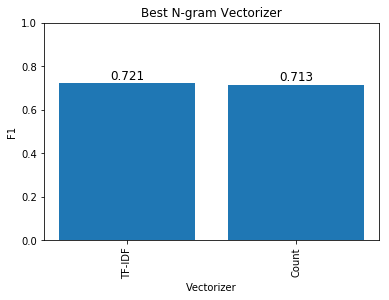

In [23]:
plotBar(
    vect_scores, 
    ticks=["TF-IDF", "Count"],
    title="Best N-gram Vectorizer",
    x_label="Vectorizer",
    y_label="F1",
    y_lim=(0,1),
    saveas="best_ngram_vect"
)

## Results

In [18]:
ngram_clf.set_params(vect__ngram_range=(1, 2), clf__C=0.1, vect__tokenizer=None)

ngram_clf.fit(train, train['label'])
ngram_score = eval_summary("Best Parameters", ngram_clf.predict(test), test['label'])


Confusion matrix:
 [[105794  35873]
 [ 46875  94792]]
Classifier 'Best Parameters' has P=0.725 R=0.669 Acc=0.708 F1=0.696
             precision    recall  f1-score   support

          0       0.69      0.75      0.72    141667
          1       0.73      0.67      0.70    141667

avg / total       0.71      0.71      0.71    283334



In [ ]:
ngram_weights = ngram_clf.steps[2][1].coef_[0, :]
vocabulary = ngram_clf.steps[1][1].vocabulary_

ngram_args = np.flip(np.argsort(ngram_weights), axis=-1)

In [ ]:
for arg in ngram_args[:30]:
    for token in vocabulary:
        if (vocabulary[token] == arg):
            print("{}: {:.2f}".format(token, ngram_weights[arg]))

In [ ]:
for arg in np.flip(ngram_args, axis=-1)[:30]:
    for token in vocabulary:
        if (vocabulary[token] == arg):
            print("{}: {:.2f}".format(token, ngram_weights[arg]))

# Parts of Speech

In [19]:
all_tags = [
    '$', '\'\'', '(', ')', ',', '--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS',
    'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
    'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', 'None'
]

all_tag_names = [
    'dollar', 'closing quotation marks', 'opening parantheses', 'closing parantheses', 'comma', 'dash',
    'sentence terminator', 'colon or elipsis', 'conjunction, coordinating', 'numeral, cardinal', 'determiner',
    'exisensial there', 'foreign word', 'preposition or conjunction, subordinating', 'adjective or numeral, ordinal',
    'adjective, comparative', 'adjective, superlative', 'list item marker', 'modal auxiliary',
    'noun, common, singular or mass', 'noun, proper, singular', 'noun, proper, plural', 'noun, common, plural', 'pre-determiner',
    'genitive marker', 'pronoun, personal', 'pronoun, possessive', 'adverb', 'adverb, comparative',
    'adverb, superlative', 'particle', 'symbol', '"to" as preposition or infinitive marker', 'interjection',
    'verb, base form', 'verb, past tense', 'verb, present participle or gerund', 'verb, past participle',
    'verb, present tense, not 3rd person singular', 'verb, present tense, 3rd person singular', 'WH-determiner',
    'WH-pronoun', 'WH-pronoun, possessive', 'Wh-adverb', 'opening quotation mark', 'None'
]

In [20]:
pos_clf = Pipeline([
    ('Selector', ColumnSelector('comment')),
    ('pos', PoSTags()),
    ('clf', LinearSVC())
])

In [21]:
pos_clf.fit(train, train['label'])

KeyboardInterrupt: 

In [ ]:
eval_summary("PoS Tags", pos_clf.predict(test), test['label'])

In [ ]:
pos_weights = pos_clf.steps[2][1].coef_[0, :]
pos_args = np.flip(np.argsort(pos_weights), axis=-1)
top_weights = list()
top_tags = list()

for arg in pos_args:
    print("{} ({}): {:.2f}".format(all_tags[arg], all_tag_names[arg], pos_weights[arg]))
    if (pos_weights[arg] > 0.5):
        top_weights.append(pos_weights[arg])
        top_tags.append(all_tags[arg])

In [ ]:
plotBar(top_weights, ticks=top_tags, title="Most Highly Weighted PoS Tags", x_label="Tag", y_label="Weighting Coefficiant", saveas="best_pos_tags")

# Topics

In [16]:
ldamodel = LdaModel.load('models/ldamodel.model')
dictionary = Dictionary.load('models/dictionary.dict')

In [32]:
topic_clf = Pipeline([
    ('selector', ColumnSelector('comment')),
    ('topics', TopicExtractor(ldaModel=ldaModel, dictionary=dictionary)),
    ('clf', LinearSVC(C=0.1))
])


Confusion matrix:
 [[744 506]
 [631 619]]
Classifier 'topics__minimum_probability - 0' has P=0.550 R=0.495 Acc=0.545 F1=0.521
             precision    recall  f1-score   support

          0       0.54      0.60      0.57      1250
          1       0.55      0.50      0.52      1250

avg / total       0.55      0.55      0.54      2500


Confusion matrix:
 [[745 505]
 [630 620]]
Classifier 'topics__minimum_probability - 0.001' has P=0.551 R=0.496 Acc=0.546 F1=0.522
             precision    recall  f1-score   support

          0       0.54      0.60      0.57      1250
          1       0.55      0.50      0.52      1250

avg / total       0.55      0.55      0.54      2500


Confusion matrix:
 [[704 546]
 [588 662]]
Classifier 'topics__minimum_probability - 0.01' has P=0.548 R=0.530 Acc=0.546 F1=0.539
             precision    recall  f1-score   support

          0       0.54      0.56      0.55      1250
          1       0.55      0.53      0.54      1250

avg / total       0.5

[0.5452, 0.546, 0.5464, 0.5524, 0.5204, 0.5092, 0.512, 0.51]

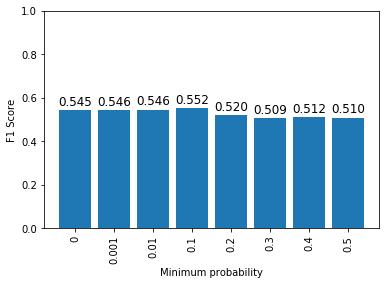

In [37]:
paramTest(
    topic_clf,
    "topics__minimum_probability",
    [0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    fname="best_topics_min_prob",
    x_label="Minimum probability"
)

In [ ]:
topic_clf.set_params(topics__minimum_probability=0.1)
topic_clf.fit(train, train['label'])

In [ ]:
eval_summary("Topics", topic_clf.predict(test), test['label'])

In [ ]:
topic_weights = topic_clf.steps[2][1].coef_[0, :]
topic_args = np.flip(np.argsort(topic_weights), axis=-1)

In [ ]:
for arg in topic_args[:10]:
    print("Topic {}: {}".format(arg, topic_weights[arg]))
    print(ldamodel.print_topic(arg))
    print()

In [ ]:
for arg in np.flip(topic_args, axis=-1)[:10]:
    print("Topic {}: {}".format(arg, topic_weights[arg]))
    print(ldamodel.print_topic(arg))
    print()

# Sentiment Difference

In [ ]:
sent_clf = Pipeline([
    ("Selector", ColumnSelector("comment")),
    ("sent_diff", SentimentDifference()),
    ("reshape", OneDReshaper()),
    ("clf", LogisticRegression())
])

sent_per_sent_clf = Pipeline([
    ("Selector", ColumnSelector("comment")),
    ("sent_diff", SentDiffPerSentence()),
    ("reshape", OneDReshaper()),
    ("clf", LogisticRegression())
])

In [ ]:
f1_scores = paramTest(sent_per_sent_clf, "sent_diff__agg", [np.mean, np.max, np.sum])

In [ ]:
sent_clf.fit(train, train['label'])
f1_scores.append(eval_summary("Overall sent diff", sent_clf.predict(test), test['label']))

In [ ]:
plotBar(
    f1_scores,
    ticks=["Mean per sentence", "Max per sentence", "Sum for sentences", "Whole comment"],
    title="Best Sentiment Difference Algorithm",
    x_label="Sentiment Difference Algorithm",
    y_label="F1 Score",
    y_lim=(0,1),
    saveas="best_sent_diff"
)

# Comment Length

In [26]:
length_clf = Pipeline([
    ("Selector", ColumnSelector("comment")),
    ("comment_length", CommentLength()),
    ("reshape", ToNpArray()),
    ("clf", LogisticRegression())
])


Confusion matrix:
 [[475 775]
 [520 730]]
Classifier 'comment_length__term - character' has P=0.485 R=0.584 Acc=0.482 F1=0.530
             precision    recall  f1-score   support

          0       0.48      0.38      0.42      1250
          1       0.49      0.58      0.53      1250

avg / total       0.48      0.48      0.48      2500


Confusion matrix:
 [[507 743]
 [547 703]]
Classifier 'comment_length__term - word' has P=0.486 R=0.562 Acc=0.484 F1=0.522
             precision    recall  f1-score   support

          0       0.48      0.41      0.44      1250
          1       0.49      0.56      0.52      1250

avg / total       0.48      0.48      0.48      2500


Confusion matrix:
 [[   8 1242]
 [   7 1243]]
Classifier 'comment_length__term - sentence' has P=0.500 R=0.994 Acc=0.500 F1=0.666
             precision    recall  f1-score   support

          0       0.53      0.01      0.01      1250
          1       0.50      0.99      0.67      1250

avg / total       0.52     

[0.52994555353902, 0.5215133531157269, 0.6655957161981259]

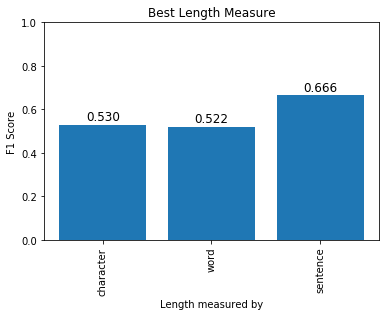

In [27]:
paramTest(
    length_clf,
    "comment_length__term",
    ["character", "word", "sentence"],
    fname="best_length_type",
    title="Best Length Measure",
    x_label="Length measured by",
)

# N-grams + 1

In [22]:
features = [
    ("parent_comments", Pipeline([
        ('selector', ColumnSelector('parent_comment')),
        ('vect', TfidfVectorizer(binary=True, ngram_range=(1,2)))
    ])),
    ("score", Pipeline([
       ('selector', ColumnSelector('score')),
       ('reshape', OneDReshaper()),
    ])),
    ("comment_length", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('n_sentences', CommentLength(term='sentence')),
        ('reshape',ToNpArray())
    ])),
    ("subreddit_sarcasm", Pipeline([
        ('sarcasm', SubredditSarcasm(history=subreddit_history)),
        ('reshape', OneDReshaper()),
    ])),
    ("author_sarcasm", Pipeline([
        ('sarcasm', AuthorSarcasm(history=author_history))
    ])),
    ("polarity", Pipeline([
       ("selector", ColumnSelector("comment")),
       ('polarity', Polarity()),
       ('reshape', OneDReshaper())
    ])),
    ("subjectivity", Pipeline([
       ("selector", ColumnSelector("comment")),
       ('polarity', Subjectivity()),
       ('reshape', OneDReshaper())
    ])),
    ("sentiment_difference", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('difference', SentDiffPerSentence()),
        ('reshape', OneDReshaper())
    ])),
    ("topics", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('topics', TopicExtractor(ldaModel=ldaModel, dictionary=dictionary)),
    ])),
    ("parent_topics", Pipeline([
        ('selector', ColumnSelector('parent_comment')),
        ('topics', TopicExtractor(ldaModel=parent_ldaModel, dictionary=parent_dictionary))
    ])),
    ("pos_tags", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('pos_tags', PoSTags())
    ])),
]

ngrams = ("n_grams", Pipeline([
    ('selector', ColumnSelector('comment')),
    ('vect', TfidfVectorizer(binary=True, ngram_range=(1,2), tokenizer=tokenize))
]))

In [23]:
scores = list()

for feature in features:
    ng_plus = Pipeline([
        ('features', FeatureUnion([ngrams, feature])),
        ('scaler', MaxAbsScaler()),
        ('clf', LogisticRegression(C=1))
    ])
    
    ng_plus.fit(train, train['label'])
    scores.append(eval_summary("Plus {}".format(feature[0]), ng_plus.predict(test), test['label']))


Confusion matrix:
 [[100516  41151]
 [ 41440 100227]]
Classifier 'Plus parent_comments' has P=0.709 R=0.707 Acc=0.709 F1=0.708
             precision    recall  f1-score   support

          0       0.71      0.71      0.71    141667
          1       0.71      0.71      0.71    141667

avg / total       0.71      0.71      0.71    283334


Confusion matrix:
 [[102296  39371]
 [ 41030 100637]]
Classifier 'Plus score' has P=0.719 R=0.710 Acc=0.716 F1=0.715
             precision    recall  f1-score   support

          0       0.71      0.72      0.72    141667
          1       0.72      0.71      0.71    141667

avg / total       0.72      0.72      0.72    283334


Confusion matrix:
 [[102295  39372]
 [ 41110 100557]]
Classifier 'Plus comment_length' has P=0.719 R=0.710 Acc=0.716 F1=0.714
             precision    recall  f1-score   support

          0       0.71      0.72      0.72    141667
          1       0.72      0.71      0.71    141667

avg / total       0.72      0.72    

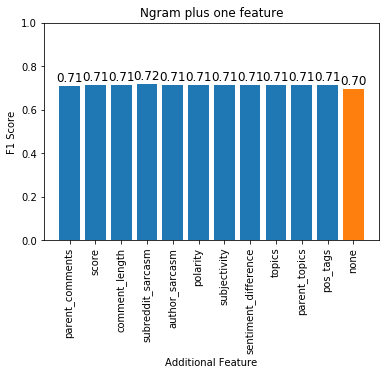

In [24]:
names = [
    "parent_comments", "score", "comment_length", "subreddit_sarcasm", "author_sarcasm", "polarity", "subjectivity",
    "sentiment_difference", "topics", "parent_topics", "pos_tags", "none"
]

plt.figure()
plt.tight_layout()

plt.bar(range(len(scores)), scores)
plt.bar(len(scores), ngram_score)

for i, f1 in enumerate(np.append(scores, ngram_score)):
    plt.text(i, f1 + 0.02, '%.2f' % f1, horizontalalignment='center', fontsize=12)
plt.xticks(range(len(names)), names, rotation='vertical')
plt.ylim(0,1)

plt.title("Ngram plus one feature")
plt.xlabel("Additional Feature")
plt.ylabel("F1 Score")

plt.savefig("graphs/ngram_plus_one.png", bbox_inches="tight")

In [25]:
for f1, name in zip(np.append(scores, ngram_score), names):
    print("{}: {}".format(name, f1))

parent_comments: 0.7082054090338992
score: 0.7145611076595366
comment_length: 0.7141933834287418
subreddit_sarcasm: 0.7172717037289605
author_sarcasm: 0.7141984559330099
polarity: 0.7143902317751434
subjectivity: 0.714205442622018
sentiment_difference: 0.7144853383017533
topics: 0.7134060501853743
parent_topics: 0.7144506452861958
pos_tags: 0.7140794712846087
none: 0.6961502871495087
